In [29]:
import numpy as np
import gym
import itertools
from gym import spaces
from gym.utils import seeding
from tqdm import tqdm
import matplotlib.pyplot as plt
from windy_gridworld import WindyGridworldEnv
from sklearn.model_selection import ParameterGrid
import pickle

In [30]:
%matplotlib inline

In [31]:
class EpsilonGreedyPolicy(object):
    
    def __init__(self, *Q, epsilon=0.1, reduction="sum", tie_breaking="random"):
        self.Q = Q  # note that Q is an array of estimates
        self.epsilon = epsilon
        self.reduction = reduction
        self.np_random = None
        self.break_ties_randomly = tie_breaking == "random"
        self.seed()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return seed
    
    def sample_action(self, state, break_ties_randomly=True):
        if self.reduction == "sum":
            q = np.array(self.Q).sum(axis=0)
        elif self.reduction == "mean":
            q = np.array(self.Q).mean(axis=0)
        else:
            raise ValueError("unknown reduction function: %s" % self.reduction)
            
        if len(self.Q) == 1:
            assert (q == self.Q[0]).all()
            
        if self.np_random.uniform() < self.epsilon:
            action = self.np_random.choice(self.Q[0].shape[1])
        
        elif self.break_ties_randomly:
            # breaks ties randomly
            action = self.np_random.choice(
                np.where(q[state] == q[state].max())[0]
            )
        else:
            # breaks ties deterministically
            action_q_values = q[state].copy()
            action = np.nanargmax(action_q_values)
        return action
    

In [32]:
def smoothing_window(vals, radius=50):
    cumvals = np.array(vals).cumsum()
    return (cumvals[radius:] - cumvals[:-radius]) / radius

In [33]:
def q_learning(
    env, policy, Q,
    num_episodes=300, discount_factor=1.0, alpha=0.5,
):
    episode_lengths = np.zeros(num_episodes)
    episode_returns = np.zeros(num_episodes)
    
    for ep in range(num_episodes):
        dur, R = 0, 0
        state = env.reset()
        while True:
            action = policy.sample_action(state)
                
            new_state, reward, done, _ = env.step(action)
            R = discount_factor * R + reward
            
            Q[state, action] += alpha * (
                reward + discount_factor * np.max(Q[new_state]) - Q[state, action]
            )
            
            state = new_state
            dur += 1
            if done:
                break
        episode_lengths[ep] += dur
        episode_returns[ep] += R
            
    return Q, (
        episode_lengths,
        episode_returns,
    )

def double_q_learning(
    env, policy, Q1, Q2,
    num_episodes=300, discount_factor=1.0, alpha=0.5, reduction="sum",
):
    episode_lengths = np.zeros(num_episodes)
    episode_returns = np.zeros(num_episodes)
    
    for ep in range(num_episodes):
        dur, R = 0, 0
        state = env.reset()
        while True:
            action = policy.sample_action(state)
            
            new_state, reward, done, _ = env.step(action)
            R = discount_factor * R + reward
            
            if np.random.uniform() <= 0.5:
                Q1[state, action] += alpha * (
                    reward + discount_factor * Q2[new_state, np.argmax(Q1[new_state])] - Q1[state, action]
                )
            else:
                Q2[state, action] += alpha * (
                    reward + discount_factor * Q1[new_state, np.argmax(Q2[new_state])] - Q2[state, action]
                )
            
            state = new_state
            dur += 1
            if done:
                break
        
        episode_lengths[ep] += dur
        episode_returns[ep] += R
            
    if reduction == "sum":
        Q = np.array([Q1, Q2]).sum(axis=0)
    elif reduction == "mean":
        Q = np.array([Q1, Q2]).mean(axis=0)
    else:
        raise ValueError("unknown reduction function: %s" % reduction)
    return Q, Q1, Q2, (
        episode_lengths,
        episode_returns,
    )

In [57]:
def q_learning_loop(env, epsilon, discount_factor, alpha, reduction, repetitions, num_episodes):
    episode_lengths_arr = []
    episode_returns_arr = []
    
    for repetition in tqdm(
        range(repetitions),
        bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
    ):
        Q = np.zeros((env.nS, env.nA))
        policy = EpsilonGreedyPolicy(Q, epsilon=epsilon, reduction=reduction)

        env.reset()

        # seed
        env.seed(42 + repetition)
        policy.seed(42 + repetition)

        Q_q_learning, (episode_lengths, episode_returns) = q_learning(
            env, policy, Q,
            num_episodes=num_episodes,
            discount_factor=discount_factor,
            alpha=alpha,
        )
        episode_lengths_arr.append(episode_lengths)
        episode_returns_arr.append(episode_returns)
        
    return (np.array(episode_lengths_arr).mean(axis=0), np.array(episode_lengths_arr).std(axis=0), 
            np.array(episode_returns_arr).mean(axis=0), np.array(episode_returns_arr).std(axis=0))
        
        
def double_q_learning_loop(env, epsilon, discount_factor, alpha, reduction, repetitions, num_episodes):
    episode_lengths_arr = []
    episode_returns_arr = []
    
    for repetition in tqdm(
        range(repetitions),
        bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
    ):
        Q1 = np.zeros((env.nS, env.nA))
        Q2 = np.zeros_like(Q1)
        policy = EpsilonGreedyPolicy(Q1, Q2, epsilon=epsilon, reduction=reduction)

        env.reset()

        # seed
        env.seed(42 + repetition)
        policy.seed(42 + repetition)

        Q_double_q_learning, _, _, (
            episode_lengths, episode_returns, 
        ) = double_q_learning(
            env, policy, Q1, Q2,
            num_episodes=num_episodes,
            discount_factor=discount_factor,
            alpha=alpha,
            reduction=reduction,
        )
        
        episode_lengths_arr.append(episode_lengths)
        episode_returns_arr.append(episode_returns)
        
    return (np.array(episode_lengths_arr).mean(axis=0), np.array(episode_lengths_arr).std(axis=0), 
            np.array(episode_returns_arr).mean(axis=0), np.array(episode_returns_arr).std(axis=0))

In [102]:
def plot_episode_lengths(episode_lengths_q_learning, episode_lengths_std_q_learning,
                         episode_lengths_double_q_learning, episode_lengths_std_double_q_learning, 
                         smoothing_radius):
    plt.figure(figsize=(15,8))
    q_learning_mean_smoothed = smoothing_window(
        episode_lengths_q_learning,
        radius=smoothing_radius
    )
    q_learning_std_smoothed = smoothing_window(
        episode_lengths_std_q_learning,
        radius=smoothing_radius
    )
    plt.plot(
        q_learning_mean_smoothed,
        label='Q-Learning',
        color="blue",
    )
    plt.fill_between(np.arange(len(q_learning_mean_smoothed)), 
                     q_learning_mean_smoothed - 0.15*q_learning_std_smoothed, 
                     q_learning_mean_smoothed + 0.15*q_learning_std_smoothed,
                     alpha=0.3, color="blue")
    
    double_q_learning_mean_smoothed = smoothing_window(
        episode_lengths_double_q_learning,
        radius=smoothing_radius
    )
    double_q_learning_std_smoothed = smoothing_window(
        episode_lengths_std_double_q_learning,
        radius=smoothing_radius
    )
    plt.plot(
        double_q_learning_mean_smoothed,
        label='Double Q-Learning',
        color="red",
    )
    plt.fill_between(np.arange(len(double_q_learning_mean_smoothed)), 
                     double_q_learning_mean_smoothed - 0.15*double_q_learning_std_smoothed, 
                     double_q_learning_mean_smoothed + 0.15*double_q_learning_std_smoothed,
                     alpha=0.3, color="red")
    
    plt.title('Average episode lengths')
    plt.xlabel("Episodes")
    plt.ylabel("Duration")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_episode_returns(episode_returns_q_learning, episode_returns_std_q_learning, 
                         episode_returns_double_q_learning, episode_returns_std_double_q_learning, 
                         smoothing_radius):
    plt.figure(figsize=(15,8))
    
    q_learning_mean_smoothed = smoothing_window(
        episode_returns_q_learning,
        radius=smoothing_radius
    )
    q_learning_std_smoothed = smoothing_window(
        episode_returns_std_q_learning,
        radius=smoothing_radius
    )
    plt.plot(
        q_learning_mean_smoothed,
        label='Q-Learning',
        color="blue",
    )
    plt.fill_between(np.arange(len(q_learning_mean_smoothed)), 
                     q_learning_mean_smoothed - 0.15*q_learning_std_smoothed, 
                     q_learning_mean_smoothed + 0.15*q_learning_std_smoothed,
                     alpha=0.3, color="b")
    
    
    double_q_learning_mean_smoothed = smoothing_window(
        episode_returns_double_q_learning,
        radius=smoothing_radius
    )
    double_q_learning_std_smoothed = smoothing_window(
        episode_returns_std_double_q_learning,
        radius=smoothing_radius
    )
    
    plt.plot(
        double_q_learning_mean_smoothed,
        label='Double Q-Learning',
        color="red",
    )
    plt.fill_between(np.arange(len(double_q_learning_mean_smoothed)), 
                     double_q_learning_mean_smoothed - 0.15*double_q_learning_std_smoothed, 
                     double_q_learning_mean_smoothed + 0.15*double_q_learning_std_smoothed,
                     alpha=0.3, color="r")
    
    plt.title('Average episodic returns')
    plt.xlabel("Episodes")
    plt.ylabel("Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [71]:
#env
env = gym.envs.make("Taxi-v3")
#env = gym.envs.make("FrozenLake-v1")
#env = gym.envs.make("Blackjack-v1")

# parameters
num_episodes=300
repetitions=10
reduction = "mean"
smoothing_radius = 10

# hyperparameters
discount_factor=1.0
alpha=0.1
epsilon=0.1

In [104]:
episode_lengths_q_learning, episode_lengths_std_q_learning, episode_returns_q_learning, \
episode_returns_std_q_learning = q_learning_loop(
    env, epsilon, discount_factor, alpha, reduction, repetitions, num_episodes
)

episode_lengths_double_q_learning, episode_lengths_std_double_q_learning, episode_returns_double_q_learning, \
episode_returns_std_double_q_learning = double_q_learning_loop(
    env, epsilon, discount_factor, alpha, reduction, repetitions, num_episodes
)

100%|██████████| 10/10 [00:55<00:00,  5.58s/it]                                           


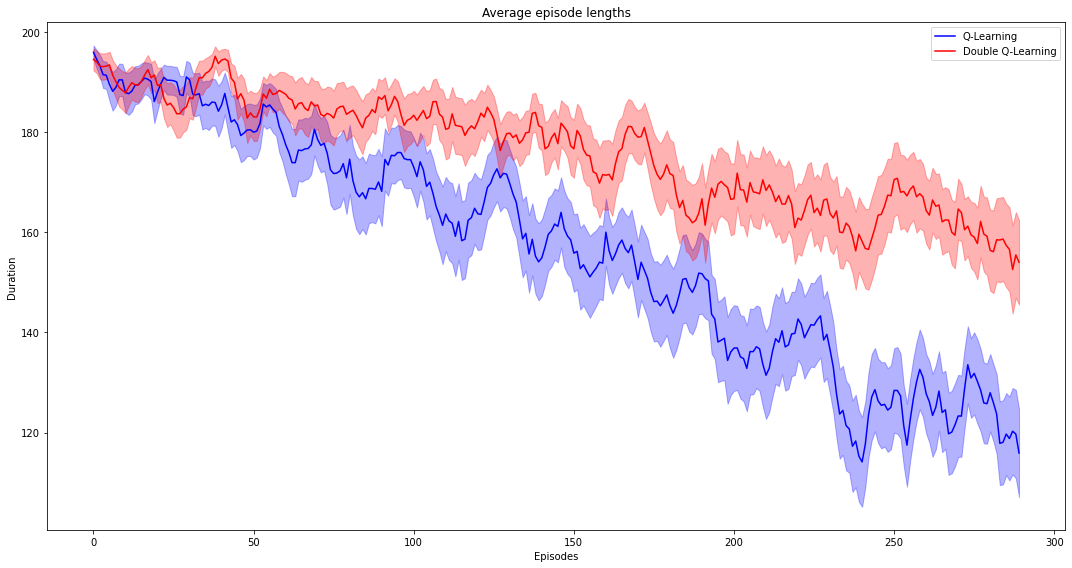

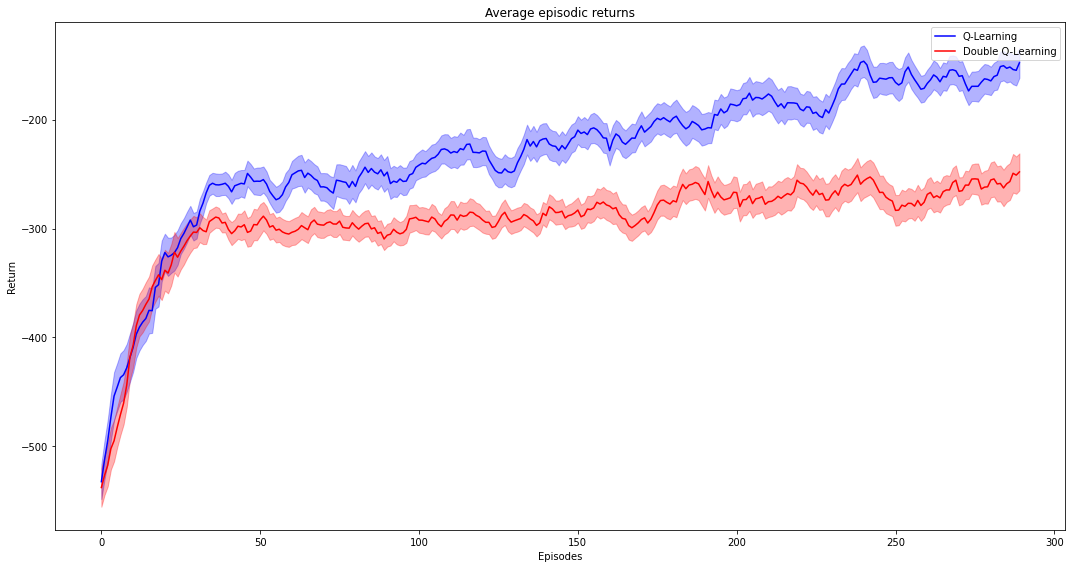

In [105]:
plot_episode_lengths(episode_lengths_q_learning, episode_lengths_std_q_learning, 
                     episode_lengths_double_q_learning, episode_lengths_std_double_q_learning, 
                     smoothing_radius)

plot_episode_returns(episode_returns_q_learning, episode_returns_std_q_learning, 
                     episode_returns_double_q_learning, episode_returns_std_double_q_learning, 
                     smoothing_radius)

In [108]:
def grid_search(env, method, alpha_range, epsilon, discount_factor, reduction, repetitions, num_episodes, file_name):
    experiment = {
        "environment": env.__class__.__name__,
        "method": method.__name__,
        "num_episodes": num_episodes,
        "repetitions": repetitions
    }
    results = {}
    
    best_alpha = None
    best_return = -np.inf
    
    for alpha in alpha_range:
        episode_lengths, _, episode_returns, _ = method(
            env, epsilon, discount_factor, alpha, reduction, repetitions, num_episodes)
        results[alpha] = {
            "episode_lengths": episode_lengths,
            "episode_returns": episode_returns
        }
        
        if episode_returns[-1] > best_return:
            best_return = episode_returns[-1]
            best_alpha = alpha
    
    experiment["results"] = results
    experiment["best_alpha"] = best_alpha
    print("Best alpha value: %.2f (reward %d)" % (best_alpha, best_return))
    
    with open(file_name, 'wb') as f:
        pickle.dump(experiment, f)

In [109]:
grid_search(env, q_learning_loop, np.linspace(0.1, 0.2, 2), 0.1, 1.0, 
           reduction, repetitions, num_episodes, "./taxi_q_learning.p")

100%|██████████| 10/10 [00:39<00:00,  3.98s/it]                                           

Best alpha value: 0.20 (reward -43)


In [110]:
with open("./taxi_q_learning.p", 'rb') as f:
    data = pickle.load(f)